# Pipelines

TOAST pipelines are standalone Python scripts that apply one or more TOAST operators to existing or simulated data. They typically divide into two major parts:
1. Creating the TOAST `data` object
2. Applying TOAST operators to the `data`

Experiments and simulations typically require specialized methods for creating the `data` object. This part is hard to generalize. For the subsequent data processing TOAST provides a number of convenience functions are kept in [toast.pipeline_tools](https://github.com/hpc4cmb/toast/tree/master/src/toast/pipeline_tools).

In [1]:
# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = "toast3"

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer


Running on NERSC machine 'cori'
  with access to repos: mp107
Using default repo mp107


## Brief example

We demonstrate these concepts by writing a very simple pipeline that creates its own observations, fills them with noise and applies a polynomial filter.

In [2]:
%%writefile my_first_pipeline.py

import argparse

import numpy as np

# import lesson_tools

import toast
from toast.mpi import MPI
import toast.pipeline_tools


# Fake focaplane is copied here from lesson_tools to avoid import error

def fake_focalplane(
    samplerate=20,
    epsilon=0,
    net=1,
    fmin=0,
    alpha=1,
    fknee=0.05,
    fwhm=30,
    npix=7,
    fov=3.0
):
    """Create a set of fake detectors.

    This generates 7 pixels (14 dets) in a hexagon layout at the boresight
    and with a made up polarization orientation.

    Args:
        None

    Returns:
        (dict):  dictionary of detectors and their properties.

    """
    from toast.tod import hex_pol_angles_radial, hex_pol_angles_qu, hex_layout

    zaxis = np.array([0, 0, 1.0])
    
    pol_A = hex_pol_angles_qu(npix)
    pol_B = hex_pol_angles_qu(npix, offset=90.0)
    
    dets_A = hex_layout(npix, fov, "", "", pol_A)
    dets_B = hex_layout(npix, fov, "", "", pol_B)
    
    dets = dict()
    for p in range(npix):
        pstr = "{:01d}".format(p)
        for d, layout in zip(["A", "B"], [dets_A, dets_B]):
            props = dict()
            props["quat"] = layout[pstr]["quat"]
            props["epsilon"] = epsilon
            props["rate"] = samplerate
            props["alpha"] = alpha
            props["NET"] = net
            props["fmin"] = fmin
            props["fknee"] = fknee
            props["fwhm_arcmin"] = fwhm
            dname = "{}{}".format(pstr, d)
            dets[dname] = props
    return dets


def parse_arguments(comm):
    """ Declare and parse command line arguments
    
    """
    parser = argparse.ArgumentParser(fromfile_prefix_chars="@")
    
    # pipeline_tools provides arguments to supported operators
    toast.pipeline_tools.add_noise_args(parser)
    toast.pipeline_tools.add_polyfilter_args(parser)
    
    # The pipeline may add its own arguments
    parser.add_argument(
        "--nsample", 
        required=False, 
        default=10000,
        type=np.int,
        help="Length of the simulation",
    )
    
    args = parser.parse_args()
    return args


def create_observations(comm, args):
    """ Create the TOAST data object using `args`
    
    This method will look very different for different pipelines.
    """
    focalplane = fake_focalplane(samplerate=args.sample_rate, fknee=1.0)
    detnames = list(sorted(focalplane.keys()))
    detquats = {x: focalplane[x]["quat"] for x in detnames}
    tod = toast.tod.TODCache(None, detnames, args.nsample, detquats=detquats)
    
    # Write some auxiliary data
    tod.write_times(stamps=np.arange(args.nsample) / args.sample_rate)
    tod.write_common_flags(flags=np.zeros(args.nsample, dtype=np.uint8))
    for d in detnames:
        tod.write_flags(detector=d, flags=np.zeros(args.nsample, dtype=np.uint8))
    
    noise = toast.pipeline_tools.get_analytic_noise(args, comm, focalplane)
    
    observation = {"tod" : tod, "noise" : noise, "name" : "obs-000", "id" : 0}
    
    data = toast.Data(comm)
    data.obs.append(observation)
    
    return data


def main():
    """ The `main` will instantiate and process the data.
    
    """
    mpiworld, procs, rank, comm = toast.pipeline_tools.get_comm()
    args = parse_arguments(comm)
    data = create_observations(comm, args)
    
    mc = 0
    name = "signal"
    tod = data.obs[0]["tod"]
    det = tod.local_dets[0]
    
    # Simulate noise, write out one detector
    toast.pipeline_tools.simulate_noise(args, comm, data, mc, cache_prefix=name)
    tod.local_signal(det, name).tofile("noise.npy")
    
    # Apply polyfilter, write the filtered data
    toast.pipeline_tools.apply_polyfilter(args, comm, data, cache_name=name)
    tod.local_signal(det, name).tofile("filtered.npy")
    

if __name__ == "__main__":
    main()

Writing my_first_pipeline.py


In [3]:
! python3 my_first_pipeline.py --help

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 4
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>
TOAST INFO: Running serially with one process at 2019-10-15 14:53:31.026816
usage: my_first_pipeline.py [-h] [--noise] [--simulate-noise] [--no-noise]
                            [--no-simulate-noise] [--sample-rate SAMPLE_RATE]
                            [--polyfilter] [--no-polyfilter]
                            [--poly-order POLY_ORDER]
                            [--common-flag-mask COMMON_FLAG_MASK]
                            [--nsample NSAMPLE]

optional arguments:
  -h, --help            show this help message and exit
  --noise               Add simulated noise
  --simulate-noise      Add simulated noise
  --no-noise            Do not add simulated noise
  --no-simulate-noise   Do not add simulated noise
  --sample-rate SAMPLE_RATE
                        Detector

In [4]:
! python3 my_first_pipeline.py --simulate-noise --polyfilter --poly-order 6 --nsample 10000

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 4
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>
TOAST INFO: Running serially with one process at 2019-10-15 14:53:41.681681
TOAST INFO: Creating noise model:  0.00 seconds (1 calls)
TOAST INFO: Simulating noise
TOAST INFO: Simulate noise:  0.04 seconds (1 calls)
TOAST INFO: Polyfiltering signal
TOAST INFO: Polynomial filtering:  0.06 seconds (1 calls)


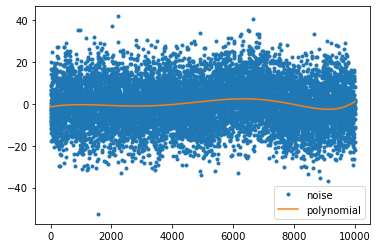

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

noise = np.fromfile("noise.npy")
filtered = np.fromfile("filtered.npy")
plt.plot(noise, '.', label="noise")
plt.plot(noise - filtered, '-', label="polynomial")
plt.legend()

## Satellite simulation pipeline

[pipelines/toast_satellite_sim.py](https://github.com/hpc4cmb/toast/blob/master/pipelines/toast_satellite_sim.py)

In [6]:
! toast_satellite_sim.py --help

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 4
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>
TOAST INFO: Running serially with one process at 2019-10-15 14:55:45.090106
usage: toast_satellite_sim.py [-h] [--group-size GROUP_SIZE] [--day-maps]
                              [--no-day-maps] [--season-maps]
                              [--no-season-maps] [--nside NSIDE]
                              [--coord COORD] [--single-precision-pointing]
                              [--no-single-precision-pointing]
                              [--common-flag-mask COMMON_FLAG_MASK] [--flush]
                              [--tidas TIDAS] [--spt3g SPT3G] [--dipole]
                              [--no-dipole] [--dipole-mode DIPOLE_MODE]
                              [--dipole-solar-speed-kms DIPOLE_SOLAR_SPEED_KMS]
                              [--dipole-solar-gal-lat-deg DIPOLE_S

`main` without the profiling commands:

```
def main():
    env = Environment.get()

    mpiworld, procs, rank, comm = get_comm()
    args, comm, groupsize = parse_arguments(comm, procs)

    # Parse options                                                                                          

    if comm.world_rank == 0:
        os.makedirs(args.outdir, exist_ok=True)

    focalplane, gain, detweights = load_focalplane(args, comm)

    data = create_observations(args, comm, focalplane, groupsize)

    expand_pointing(args, comm, data)

    localpix, localsm, subnpix = get_submaps(args, comm, data)

    signalname = None
    skyname = simulate_sky_signal(
        args, comm, data, [focalplane], subnpix, localsm, "signal"
    )
    if skyname is not None:
        signalname = skyname

    diponame = simulate_dipole(args, comm, data, "signal")
    if diponame is not None:
        signalname = diponame

    # Mapmaking                                                                                         

    if not args.use_madam:
        # THIS BRANCH WILL SOON BE REPLACED WITH THE NATIVE MAPMAKER
    else:
        # Initialize madam parameters                                                                                          

        madampars = setup_madam(args)

        # Loop over Monte Carlos                                                                                         

        firstmc = args.MC_start
        nmc = args.MC_count

        for mc in range(firstmc, firstmc + nmc):
            # create output directory for this realization
            outpath = os.path.join(args.outdir, "mc_{:03d}".format(mc))

            simulate_noise(args, comm, data, mc, "tot_signal", overwrite=True)

            # add sky signal
            add_signal(args, comm, data, "tot_signal", signalname)

            if gain is not None:
                op_apply_gain = OpApplyGain(gain, name="tot_signal")
                op_apply_gain.exec(data)

            apply_madam(args, comm, data, madampars, outpath, detweights, "tot_signal")

```

## Ground simulation pipeline

[pipelines/toast_ground_sim.py](https://github.com/hpc4cmb/toast/blob/master/pipelines/toast_ground_sim.py)

In [7]:
! toast_ground_sim.py --help

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 4
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>
TOAST INFO: Running serially with one process at 2019-10-15 15:01:58.584912
usage: toast_ground_sim.py [-h] [--group-size GROUP_SIZE] [--day-maps]
                           [--no-day-maps] [--season-maps] [--no-season-maps]
                           [--debug] [--no-debug] [--scan-rate SCAN_RATE]
                           [--scan-accel SCAN_ACCEL]
                           [--sun-angle-min SUN_ANGLE_MIN] --schedule SCHEDULE
                           [--weather WEATHER] [--timezone TIMEZONE]
                           [--sample-rate SAMPLE_RATE] [--coord COORD]
                           [--split-schedule SPLIT_SCHEDULE] [--sort-schedule]
                           [--no-sort-schedule] [--hwp-rpm HWP_RPM]
                           [--hwp-step-deg HWP_STEP_DEG]
          

`main` without profiling
```
def main():
    mpiworld, procs, rank, comm = get_comm()

    args, comm = parse_arguments(comm)

    # Initialize madam parameters                                                                                          

    madampars = setup_madam(args)

    # Load and broadcast the schedule file                                                                                         

    schedules = load_schedule(args, comm)

    # Load the weather and append to schedules                                                                                         

    load_weather(args, comm, schedules)

    # load or simulate the focalplane                                                                                          

    detweights = load_focalplanes(args, comm, schedules)

    # Create the TOAST data object to match the schedule.  This will                                                                                         
    # include simulating the boresight pointing                                                                                         

    data, telescope_data = create_observations(args, comm, schedules)

    # Split the communicator for day and season mapmaking                                                                                          

    time_comms = get_time_communicators(args, comm, data)

    # Expand boresight quaternions into detector pointing weights and                                                                                          
    # pixel numbers                                                                                          

    expand_pointing(args, comm, data)

    # Purge the pointing if we are NOT going to export the                                                                                         
    # data to a TIDAS volume                                                                                         
    if (args.tidas is None) and (args.spt3g is None):
        for ob in data.obs:
            tod = ob["tod"]
            tod.free_radec_quats()

    # Prepare auxiliary information for distributed map objects                                                                                          

    _, localsm, subnpix = get_submaps(args, comm, data)

    if args.pysm_model:
        focalplanes = [s.telescope.focalplane.detector_data for s in schedules]
        signalname = simulate_sky_signal(
            args, comm, data, focalplanes, subnpix, localsm, "signal"
        )
    else:
        signalname = scan_sky_signal(args, comm, data, localsm, subnpix, "signal")

    # Set up objects to take copies of the TOD at appropriate times                                                                                          

    totalname, totalname_freq = setup_sigcopy(args)

    # Loop over Monte Carlos

    firstmc = args.MC_start
    nsimu = args.MC_count

    freqs = [float(freq) for freq in args.freq.split(",")]
    nfreq = len(freqs)

    for mc in range(firstmc, firstmc + nsimu):

        simulate_atmosphere(args, comm, data, mc, totalname)

        # Loop over frequencies with identical focal planes and identical                                                                                          
        # atmospheric noise                                                                                         

        for ifreq, freq in enumerate(freqs):
            # Make a copy of the atmosphere so we can scramble the gains and apply                                                                                         
            # frequency-dependent scaling
            
            copy_signal(args, comm, data, totalname, totalname_freq)

            scale_atmosphere_by_frequency(
                args, comm, data, freq=freq, mc=mc, cache_name=totalname_freq
            )

            update_atmospheric_noise_weights(args, comm, data, freq, mc)

            # Add previously simulated sky signal to the atmospheric noise                                                                                          

            add_signal(args, comm, data, totalname_freq, signalname, purge=(nsimu == 1))

            mcoffset = ifreq * 1000000

            simulate_noise(args, comm, data, mc + mcoffset, totalname_freq)

            simulate_sss(args, comm, data, mc + mcoffset, totalname_freq)

            scramble_gains(args, comm, data, mc + mcoffset, totalname_freq)

            if (mc == firstmc) and (ifreq == 0):
                # For the first realization and frequency, optionally                                                                                                                                                                                                                 
                # export the timestream data
                
                output_tidas(args, comm, data, totalname)
                output_spt3g(args, comm, data, totalname)

            outpath = setup_output(args, comm, mc + mcoffset, freq)

            # Bin and destripe maps                                                                                          

            apply_madam(
                args,
                comm,
                data,
                madampars,
                outpath,
                detweights,
                totalname_freq,
                freq=freq,
                time_comms=time_comms,
                telescope_data=telescope_data,
                first_call=(mc == firstmc),
            )

            if args.apply_polyfilter or args.apply_groundfilter:

                # Filter signal                                                                                          

                apply_polyfilter(args, comm, data, totalname_freq)

                apply_groundfilter(args, comm, data, totalname_freq)

                # Bin filtered maps                                                                                          

                apply_madam(
                    args,
                    comm,
                    data,
                    madampars,
                    outpath,
                    detweights,
                    totalname_freq,
                    freq=freq,
                    time_comms=time_comms,
                    telescope_data=telescope_data,
                    first_call=False,
                    extra_prefix="filtered",
                    bin_only=True,
                )

```

Here is a full working example of the ground simulation pipeline

First we need an observing schedule.  This one is for one patch and covers 24 hours:

In [8]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 00:00:00" \
    --stop "2020-01-02 00:00:00" \
    --patch-coord C \
    --patch small_patch,1,40,-40,10 \
    --el-min 45 \
    --el-max 60 \
    --out schedule.txt

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.13 seconds (1 calls)
#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 02:00:00  2020-01-01 02:14:30    58849.083333   58849.093403 small_patch                           217.44   234.41    59.64 S       -30.65   221.82   -32.81   218.83    19.11   267.74    15.85   266.47  0.31     0   0
 2020-01-01 02:14:40  2020-01-01 02:29:10    58849.093519   58849.103588 small_patch                           217.53   238.45    59.64 S       -32.83   218.80   -34.85   215.60    15.81   266.45    12.55   265.18  0.31     0   1


Then we need a focalplane

In [9]:
! toast_fake_focalplane.py \
    --minpix 100 \
    --out focalplane \
    --fwhm 30 \
    --fwhm_sigma 0.05 \
    --fov 10 \
    --psd_fknee 5e-2 \
    --psd_NET 1e-3 \
    --psd_alpha 1 \
    --psd_fmin 1e-5 \
    --bandcenter_ghz 100 \
    --bandcenter_sigma 0.01 \
    --bandwidth_ghz 10 \
    --bandwidth_sigma 0.1

TOAST INFO: using 127 pixels (254 detectors)


And of course we need the weather file

In [10]:
! [[ ! -e weather_Atacama.fits ]] && wget http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits

--2019-10-15 15:14:04--  http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits [following]
--2019-10-15 15:14:04--  https://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180160 (2.1M) [image/fits]
Saving to: ‘weather_Atacama.fits’

weather_Atacama.fit 100%[===================>]   2.08M  --.-KB/s    in 0.007s  

2019-10-15 15:14:04 (287 MB/s) - ‘weather_Atacama.fits’ saved [2180160/2180160]



Now write a parameter file that uses the above inputs and simulates sky signal (using PySM), atmosphere and instrument noise

In [11]:
%%writefile toast_ground_sim.par
--weather
weather_Atacama.fits
--scan-rate
1
--scan-accel
3
--schedule
schedule.txt
--sample-rate
30
--coord
C
--hwp-rpm
2
--nside
512
--common-flag-mask
1
--polyfilter
--poly-order
5
--groundfilter
--ground-order
3
--atmosphere
--atm-lmin-center
0.1
--atm-lmax-center
30
--atm-gain
3e-5
--atm-zmax
1000
--atm-xstep
30
--atm-ystep
30
--atm-zstep
30
--atm-nelem-sim-max
10000
--atm-wind-dist
5000
--atm-cache
atm_cache
--noise
--gainscrambler
--gain-sigma
0.05
--madam-prefix
groundsim000
--madam-iter-max
200
--madam-precond-width
100
--madam-baseline-length
1
--madam-noisefilter
--madam-allreduce
--destripe
--binmap
--hits
--wcov
--ground-nside
512
--ground-fwhm-deg
3
--ground-lmax
512
--ground-scale
1e-3
--simulate-ground
--focalplane
focalplane_127.pkl
--freq
100
--pysm-model
s1,d1,f1,a1
--pysm-apply-beam

Writing toast_ground_sim.par


With the PySM part (last three lines) the simulation will take about 20 minutes on a single Cori Haswell node.  If you remove them, it will run in about 4 minutes.

Finally, instead of submitting the job interactively with srun, we write an actual script and submit it.

In [12]:
%%writefile toast_ground_sim.slrm
#!/bin/bash
#SBATCH --partition=regular
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --job-name=toast_ground_sim
#SBATCH --licenses=SCRATCH
#SBATCH --constraint=haswell
#SBATCH --account=mp107

ulimit -c unlimited

export MALLOC_MMAP_THRESHOLD_=131072
export PYTHONSTARTUP=""
export PYTHONNOUSERSITE=1
export HOME=/global/cscratch1/sd/keskital

export OMP_NUM_THREADS=2
export OMP_PLACES=threads
export OMP_PROC_BIND=spread

let nnode=1
let ntask_node=32/$OMP_NUM_THREADS
let ntask=$nnode*$ntask_node
let ncore=2*$OMP_NUM_THREADS

srun -n $ntask -c $ncore --cpu_bind=cores \
    toast_ground_sim.py \
    @toast_ground_sim.par \
    >& toast_ground_sim.log

Writing toast_ground_sim.slrm


The `sbatch` command below is commented out so it does not get executed every time this notebook runs.

In [13]:
# ! sbatch toast_ground_sim.slrm

Here we examine the intensity part of the simulated maps.

In [14]:
import healpy as hp
try:
    binned = hp.read_map("out/00000000/100/groundsim000_100_telescope_all_time_all_bmap.fits")
    destriped = hp.read_map("out/00000000/100/groundsim000_100_telescope_all_time_all_map.fits")
    filtered = hp.read_map("out/00000000/100/groundsim000_filtered_100_telescope_all_time_all_bmap.fits")

    rot = [40, -40]
    reso = 10
    cmap = "coolwarm"
    amp = 0.02
    unit = "K"
    plt.figure(figsize=[12, 8])
    hp.gnomview(binned, rot=rot, reso=reso, cmap=cmap, min=-amp, max=amp, sub=[1, 3, 1], title="binned", unit=unit)
    hp.gnomview(destriped, rot=rot, reso=reso, cmap=cmap, min=-amp, max=amp, sub=[1, 3, 2], title="destriped", unit=unit)
    hp.gnomview(filtered, rot=rot, reso=reso, cmap=cmap, min=-amp, max=amp, sub=[1, 3, 3], title="filtered", unit=unit)
except:
    print("Maps are not available.  `Either toast_ground_sim.slrm` failed or you did not submit it yet.")

Maps are not available.  `Either toast_ground_sim.slrm` failed or you did not submit it yet.
